**Test Script**: This script has the code for testing the trained CNN models.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
cd /content/drive/Shareddrives/Projeto DACO/scripts code

/content/drive/Shareddrives/Projeto DACO/scripts code


In [ ]:
pip install torchinfo

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
pip install import-ipynb

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 22.0 MB/s eta 0:00:00


In [ ]:
import torch
from torch import nn
from torch.utils.data import DataLoader
from torch import optim
from torchvision.ops.focal_loss import sigmoid_focal_loss
import albumentations as A
from albumentations.pytorch import ToTensorV2
from time import time
from tqdm import tqdm
from torchinfo import summary
import datetime
import importlib
import os
import argparse
import numpy as np
import pandas as pd
import torch.nn.functional as F
import torchvision.models as models

import matplotlib.pyplot as plt
from sklearn import metrics
from sklearn.utils import class_weight

# Dataloader
import import_ipynb
from dataloader import small_dataset
from sklearn import preprocessing


from sklearn.model_selection import train_test_split

device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f'Using {device}')

importing Jupyter notebook from dataloader.ipynb
Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Detection's Label Map
Class 0 -  ['hemorrhage']
Class 1 -  ['no hemorrhage']

Classification's Label Map
Class 0 -  [' epidural']
Class 1 -  [' intraparenchymal']
Class 2 -  [' intraventricular']
Class 3 -  [' subarachnoid']
Class 4 -  [' subdural']
Class 5 -  ['no hemorrhage']
[10.925       0.99036827  1.52663755  0.90805195  0.46675567]
Using cuda


/usr/local/lib/python3.8/dist-packages/pandas/core/frame.py:4906: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


In [ ]:
class VGG16(nn.Module):
    def __init__(self, num_classes=5):
        super(VGG16, self).__init__()
        self.layer1 = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU())
        self.layer2 = nn.Sequential(
            nn.Conv2d(64, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(), 
            nn.MaxPool2d(kernel_size = 2, stride = 2))
        self.layer3 = nn.Sequential(
            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU())
        self.layer4 = nn.Sequential(
            nn.Conv2d(128, 128, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size = 2, stride = 2))
        self.layer5 = nn.Sequential(
            nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU())
        self.layer6 = nn.Sequential(
            nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU())
        self.layer7 = nn.Sequential(
            nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size = 2, stride = 2))
        self.layer8 = nn.Sequential(
            nn.Conv2d(256, 512, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU())
        self.layer9 = nn.Sequential(
            nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU())
        self.layer10 = nn.Sequential(
            nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size = 2, stride = 2))
        self.layer11 = nn.Sequential(
            nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU())
        self.layer12 = nn.Sequential(
            nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU())
        self.layer13 = nn.Sequential(
            nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size = 2, stride = 2))
        self.fc = nn.Sequential(
            nn.Dropout(0.5),
            nn.Linear(7*7*512, 4096),
            nn.ReLU())
        self.fc1 = nn.Sequential(
            nn.Dropout(0.5),
            nn.Linear(4096, 4096),
            nn.ReLU())
        self.fc2= nn.Sequential(
            nn.Linear(4096, num_classes))
        
    def forward(self, x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        out = self.layer5(out)
        out = self.layer6(out)
        out = self.layer7(out)
        out = self.layer8(out)
        out = self.layer9(out)
        out = self.layer10(out)
        out = self.layer11(out)
        out = self.layer12(out)
        out = self.layer13(out)
        out = out.reshape(out.size(0), -1)
        out = self.fc(out)
        out = self.fc1(out)
        out = self.fc2(out)
        return out

In [ ]:
###################### TESTING #####################

dataset_fold = 'windowing' # ['original', 'windowing']
model_selected = 'ResNeXt' # ['VGG', 'ResNeXt']

print(f'Testing Mode using {dataset_fold} images')

################## PARAMETERS ##################

img_size = 224
BATCH_SIZE = 1

Testing Mode using windowing images


In [ ]:
import seaborn as sns

def evaluation_metrics (true_label, final_pred):
  # Confusion matrix
    confusion_matrix = metrics.confusion_matrix(true_label, final_pred, labels = [0,1,2,3,4])
    cmn = confusion_matrix.astype('float') / confusion_matrix.sum(axis=1)[:, np.newaxis]
    fig, ax = plt.subplots(figsize=(8,8))
    sns.heatmap(cmn, annot=True, fmt='.2f', xticklabels=['epi','intrap','intrav','suba','subd'], yticklabels=['epi','intrap','intrav','suba','subd'])
    plt.ylabel('True')
    plt.xlabel('Predicted')
    plt.show(block=False)


def evaluation_metrics_detect (true_label, final_pred):
  # Confusion matrix
    confusion_matrix = metrics.confusion_matrix(true_label, final_pred, labels = [0,1])
    cmn = confusion_matrix.astype('float') / confusion_matrix.sum(axis=1)[:, np.newaxis]
    fig, ax = plt.subplots(figsize=(8,8))
    sns.heatmap(cmn, annot=True, fmt='.2f', xticklabels=['hemorrhage','no hemorrhage'], yticklabels=['hemorrhage','no hemorrhage'])
    plt.ylabel('True')
    plt.xlabel('Predicted')
    plt.show(block=False)

In [ ]:
################## DATA LOADING AND MODEL ##################

# Data albumentations
aug_2 = [
    A.Resize(img_size + img_size//20, img_size + img_size//20),
    A.RandomCrop(img_size, img_size),
    ToTensorV2()
]

transforms = A.Compose(aug_2)

# Data Splitting

print ("Loading dataset\n")
 
detection_dataset = pd.read_csv('/content/drive/Shareddrives/Projeto DACO/single label dataset/dataset_labels.csv')

label_encoder_1 = preprocessing.LabelEncoder()
detection_dataset ['presence'] = label_encoder_1.fit_transform(detection_dataset ['presence'])

label_encoder_2 = preprocessing.LabelEncoder()
detection_dataset ['type'] = label_encoder_2.fit_transform(detection_dataset ['type'])

# Labels map
print("Detection's Label Map")
print("Class 0 - ", label_encoder_1.inverse_transform([0]))
print("Class 1 - ", label_encoder_1.inverse_transform([1]))

print("\nClassification's Label Map")
print("Class 0 - ", label_encoder_2.inverse_transform([0]))
print("Class 1 - ", label_encoder_2.inverse_transform([1]))
print("Class 2 - ", label_encoder_2.inverse_transform([2]))
print("Class 3 - ", label_encoder_2.inverse_transform([3]))
print("Class 4 - ", label_encoder_2.inverse_transform([4]))
print("Class 5 - ", label_encoder_2.inverse_transform([5]))

d_train_set, d_val_set = train_test_split(detection_dataset, test_size=0.3, random_state=123)
d_val_set, d_test_set = train_test_split(d_val_set, test_size=0.5, random_state=123)

# Classification dataset consist of the detection dataset with only the positive cases
classification_dataset = detection_dataset[detection_dataset['presence']==0]

# Computed before eliminating the images for the test dataset
class_weights_c = class_weight.compute_class_weight(
              class_weight='balanced',
              classes=[0, 1, 2, 3, 4], # the label 5 is not included since the classification_dataset DOES NOT HAVE images from class 5 (because of the previous code line)
              y=classification_dataset['type'])

class_weights_d = class_weight.compute_class_weight(
              class_weight='balanced',
              classes=[0, 1], 
              y=detection_dataset['presence'])

c_test_set = d_test_set[d_test_set['presence']==0]

d_test_set, c_test_set = d_test_set.reset_index(drop=True), c_test_set.reset_index(drop=True)

d_test_set, c_test_set = small_dataset(d_test_set, dataset_fold, transforms), small_dataset(c_test_set, dataset_fold, transforms)

dtest = DataLoader(d_test_set, batch_size=BATCH_SIZE, shuffle=False)
ctest = DataLoader(c_test_set, batch_size=BATCH_SIZE, shuffle=False)

print ("\nLoaded \n")

# Model

if (model_selected == 'VGG'):
  model_detect, model_classify = VGG16(num_classes=2), VGG16(num_classes=5)

elif (model_selected == 'ResNeXt'):
  ResNeXt_d = models.resnext101_32x8d(pretrained=False, num_classes=2)
  ResNeXt_c = models.resnext101_32x8d(pretrained=False, num_classes=5)
  model_detect, model_classify = ResNeXt_d, ResNeXt_c

model_detect.load_state_dict(torch.load(f'/content/drive/Shareddrives/Projeto DACO/scripts code/DETECTION {model_selected} FINAL/{model_selected}_detection_latest_model.pth', map_location=torch.device('cpu')))
model_detect.to(device)

model_classify.load_state_dict(torch.load(f'/content/drive/Shareddrives/Projeto DACO/scripts code/CLASSIFICATION {model_selected} FINAL/{model_selected}_classification_latest_model.pth', map_location=torch.device('cpu')))
model_classify.to(device)

Loading dataset

Detection's Label Map
Class 0 -  ['hemorrhage']
Class 1 -  ['no hemorrhage']

Classification's Label Map
Class 0 -  [' epidural']
Class 1 -  [' intraparenchymal']
Class 2 -  [' intraventricular']
Class 3 -  [' subarachnoid']
Class 4 -  [' subdural']
Class 5 -  ['no hemorrhage']

Loaded 



ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
      (bn2): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(256, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1

In [ ]:
###################### DETECTION TEST #######################

true_labels_d = []
final_preds_d = []

sample_weights_d = []

model_detect.eval()

with torch.set_grad_enabled(False):
  
  for img, label_d, label_c in tqdm(dtest):
      img = img.to(device)
      
      true_labels_d.append(int(label_d.detach().numpy()))
      sample_weights_d.append(class_weights_d[int(label_d.detach().numpy())])

      label_pred = model_detect(img)

      y_pred = torch.softmax(label_pred, dim=1).argmax(dim=1)

      final_preds_d.append(int(y_pred.cpu().detach().numpy()))

100%|██████████| 1275/1275 [08:07<00:00,  2.62it/s]


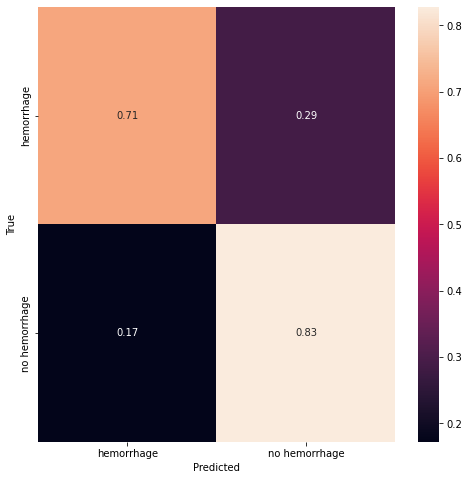

0.5431180587657567
0.8010403120936281
0.8279569892473119


In [ ]:
evaluation_metrics_detect (true_labels_d, final_preds_d)

from sklearn.metrics import matthews_corrcoef
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score

m_coef = matthews_corrcoef(true_labels_d, final_preds_d, sample_weight = sample_weights_d)
precision = precision_score(true_labels_d, final_preds_d, average = 'binary')
recall = recall_score(true_labels_d, final_preds_d, average = 'binary')

print(m_coef)
print(precision)
print(recall)

In [ ]:
###################### CLASSIFICATION TEST #######################

true_labels_c = []
final_preds_c = []

sample_weights_c = []

model_classify.eval()


with torch.set_grad_enabled(False):
  
  for img, label_d, label_c in tqdm(ctest):
      img = img.to(device)
      
      true_labels_c.append(int(label_c.detach().numpy()))
      sample_weights_c.append(class_weights_c[int(label_c.detach().numpy())])

      label_pred = model_classify(img)

      y_pred = torch.softmax(label_pred, dim=1).argmax(dim=1)

      final_preds_c.append(int(y_pred.cpu().detach().numpy()))
      

100%|██████████| 531/531 [00:20<00:00, 25.44it/s]


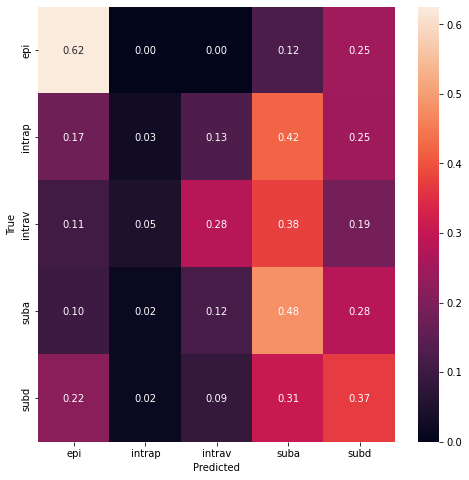

0.19286840867270238
0.3902925221606397
0.3163841807909605


In [ ]:
evaluation_metrics(true_labels_c, final_preds_c)

from sklearn.metrics import matthews_corrcoef

m_coef = matthews_corrcoef(true_labels_c, final_preds_c, sample_weight = sample_weights_c)
precision = precision_score(true_labels_c, final_preds_c, average = 'weighted')
recall = recall_score(true_labels_c, final_preds_c, average = 'weighted')

print(m_coef)
print(precision)
print(recall)

In [ ]:
if (model_selected == 'VGG'):
  
  from pytorch_grad_cam import GradCAM
  from pytorch_grad_cam.utils.model_targets import ClassifierOutputTarget
  from pytorch_grad_cam.utils.image import show_cam_on_image, \
      deprocess_image, \
      preprocess_image
  import cv2
  from PIL import Image

  model_classify.to('cpu')
  model_classify.eval()

  # Saves GRADCAM results for all the test images
  for i in range(len(grad_cam_set)):
    img, label_d, label_c = grad_cam_set[i]

    # Necessary preprocessing
    img = cv2.resize(img, (224, 224))
    img = np.float32(img) / 255


    input_tensor = torch.tensor(img).permute(2,0,1) 
    input_tensor = input_tensor[None, :, :, :] # "dummy axis" to change the tensor into 4D

    targets = [ClassifierOutputTarget(label_c)]
    target_layers = [model_classify.layer13[-1]] 

    with GradCAM(model=model_classify, target_layers=target_layers, use_cuda=True) as cam:
        grayscale_cams = cam(input_tensor=input_tensor, targets=targets)
        cam_image = show_cam_on_image(img, grayscale_cams[0, :], use_rgb=True)
    cam = np.uint8(255*grayscale_cams[0, :])
    cam = cv2.merge([cam, cam, cam])
    images = np.hstack((np.uint8(255*img), cam , cam_image))
    Image.fromarray(images)


    cv2.imwrite(f'/content/drive/Shareddrives/Projeto DACO/scripts code/gradcam images/img_{i}_label_{label_c}.png', cv2.cvtColor(images, cv2.COLOR_RGB2BGR))   